In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.functions import col,isnan,when,count
import pandas as pd
from IPython.display import Image, display
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/08 12:15:38 WARN Utils: Your hostname, Zhangs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.11.64 instead (on interface en0)
22/10/08 12:15:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 12:15:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/08 12:15:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/08 12:15:39 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# read all the dataframe
transaction = spark.read.parquet('../data/curated/final_transaction.parquet')
merchants = spark.read.parquet('../data/curated/final_merchant.parquet')
census = spark.read.parquet('../data/curated/final_census.parquet')
final = spark.read.parquet('../data/curated/merchant_info.parquet')

pure_add_rank = pd.read_parquet('../data/curated/baseline.parquet')
sorted_self_weight_score = pd.read_parquet('../data/curated/self_weight.parquet')
entropy_score = pd.read_parquet('../data/curated/entropy_weight.parquet')
sum_rank = pd.read_parquet('../data/curated/sum_rank.parquet')
study_score = pd.read_parquet('../data/curated/study_score_rank.parquet')
top_100 = pd.read_parquet('../data/curated/top_100.parquet')
art_combine = pd.read_parquet('../data/curated/art_combine.parquet')
sports_combine = pd.read_parquet('../data/curated/sports_combine.parquet')
technology_combine = pd.read_parquet('../data/curated/technology_combine.parquet')
home_combine = pd.read_parquet('../data/curated/home_combine.parquet')
health_combine = pd.read_parquet('../data/curated/health_combine.parquet')
compare_feature_rank = pd.read_parquet('../data/curated/compare_feature_rank.parquet')


# Summary Notebook

## 1. Pre-processing of the provided raw dataset as well as the found external data

### 1.1 Provided dataset
#### 1.1.1 For transaction data:  

a. Combine all the original transaction table into one dataframe, total num of rows bsfore null value check is 14195505.  
  
i) First check all the data for null values, and no null values are found.  
ii) For order datetime check whether in the range from 2021-02-28 to 2022-08-28, 1634128 rows of data are deleted. Num of rows after date check is 12561377.  
iii) Check all transaction amounts (<font color = #deab8a>'dollar_value'</font>) for each company for outliers,and delete outliers for each company. Total 1502453 rows are deleted. Num of rows after delete outlier is 11058924.  

b. Create a new feature for whether it is a large order (artificially set the transaction with a dollar value greater than 10,000 as a large order. If it is a large order, mark it as 1, if not, mark it as 0).  


#### 1.1.2 For fraud data:  

a. Check the null value and whether in the range from 2021-02-28 to 2022-08-28, no data is deleted, total 34864 rows.  
b. Create a new feature for whether it is fraud (artificially set the fraud probability as larger than 70%  If it is larger than 70%, assumed fraud mark it as 1, if not, mark it as 0).

In [3]:
transaction.limit(3)

user_id,merchant_abn,dollar_value,order_datetime,whether_bigorder,postcode,average_prob_con,whether_fraud
4748,24406529929,90.0893800907789,2022-05-22,0,3373,10.256077060613642,0
4748,73841664453,20.57693546236876,2021-08-08,0,3373,10.256077060613642,0
4748,83412691377,41.21691457183529,2022-03-07,0,3373,10.256077060613642,0


#### 1.1.3 For merchant data:  

Total 4422 merchants.  
Separate the tag into 3 features: 'Store_type', 'Revenue_levels', 'Take_rate'


In [4]:
merchants.limit(3)

merchant_abn,Store_type,Revenue_levels,Take_rate
10023283211,"furniture, home f...",e,0.18
10142254217,"cable, satellite,...",b,4.22
10165489824,"jewelry, watch, c...",b,4.40


### 1.2 External dataset
#### 1.2.1 For census data:  

Select age and income tables. In each SA2 region,  
a. calculate the proportion of the age group between 20-64 in total number of people in that region (Assume this age group has a higher level of consumption).  
b. calculate the proportion of people earning above the Australian weekly median income ($1200) to the total number of people (Assume the higher the proportion in this area, the higher the level of consumption).


In [5]:
census.limit(3)

SA2_CODE_2021,income_percentage,age_percentage
103021063,0.16390423572744015,0.49908336029332473
103021064,0.17449106771915246,0.5138208537438769
118021654,0.39097577239386533,0.5578328283728391


## 2. Combine table

### 2.1 Combine transaction information into merchant  

a. Obtain the average monthly order amount(<font color = #deab8a>'Avg_amount_monthly'</font>), count(<font color = #deab8a>'Avg_count_monthly'</font>), and amount per order for each company('Order_avg_value') and the number of large orders(<font color = #deab8a>'count_of_bigorder'</font>).  
b. Estimate the monthly amount BNPL can earn if they work with the merchant by average monthly order amount times take rate(<font color = #deab8a>'Take_rate'</font>).    
c. Obtain the average number of different customers per month for each merchant(<font color = #deab8a>'count_cus_per_mon'</font>), the average probability of fraud for all customers(<font color = #deab8a>'avg_prob_fraud_cus'</font>), and the percentage of those customers who are fraudulent out of the total number of customers(<font color = #deab8a>'prob_num_of_fraud'</font>).  
d. Find the number of people who came more than or equal to 5 times in 18 months as regular customers(<font color = #deab8a>'fix_cus_num'</font>).    

### 2.2 Combine census information into merchant 

a. Take the most common postcode of all customers of each merchant, and then guess that this postcode is the merchant's postcode(<font color = #deab8a>'postcode'</font>).     
b. After converting SA2 of census data into postcode, merging them with the estimated merchant postcode to obtain the census information for each merchant's location(<font color = #deab8a>'avg_income_percentage', 'avg_age_percentage'</font>).

In [6]:
final.limit(3)

Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,postcode,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,merchant_abn,fix_cus_num,avg_income_percentage,avg_age_percentage
shoe shops,b,5088.108,0,1169.68,3.28,356.85,1660,16.41769282602561,0.0,3.28,42330360779,0,0.3924226684563543,0.5395286144327325
"opticians, optica...",a,8020.69,0,1289.5,21.56,59.82,1660,15.594208059208613,0.0,21.28,73221370757,0,0.3924226684563543,0.5395286144327325
art dealers and g...,c,5908.3479,0,3126.11,2.44,1278.86,2482,14.965341864244008,0.0,2.44,97598804219,0,0.19071467244179752,0.5701438848920863


## 3. Visualization

### 3.1 Visualization

##### The relationship between the average amount per order and the percentage of fraud people for the merchant

As the order amount becomes larger, the ratio of the number of scammed people to the total number of customers does not become larger with it.  Although some outliers can be found on the graph, they do not affect the overall trend of the data distribution. The overall trend of the data is decreasing, with the probability of being scammed remaining the same or decreasing slightly as the order amount increases. Most of the probabilities are concentrated between 0-0.2, and the transaction amounts are roughly concentrated between 0-200,000.

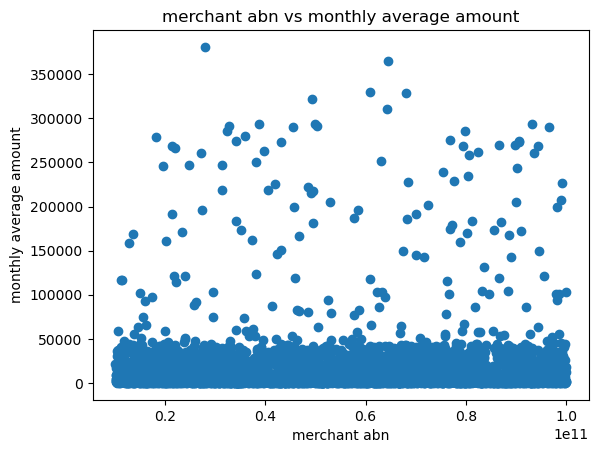

In [7]:
listOfImageNames = ['../plots/abn_vs_amount.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of the average value of each order

The companies with value of order below 134 are the most numerous. The image becomes a continuous downward trend, as the higher the amount the smaller the number of merchants that fit the range. This is also consistent with common sense, as small orders tend to be more prevalent than large orders.

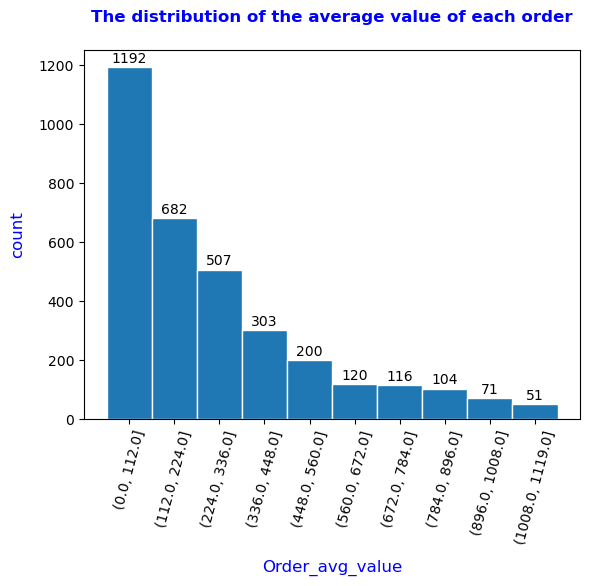

In [8]:
listOfImageNames = ['../plots/avg_value_per_order.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of average number of different consumer per month per shop

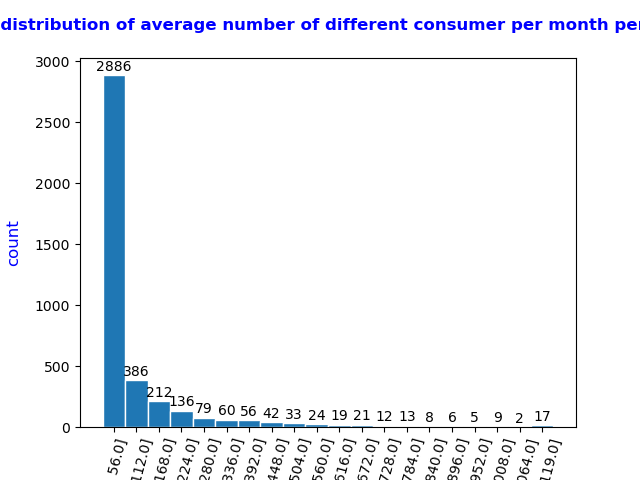

In [9]:
listOfImageNames = ['../plots/num_of_customer_per_month.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of the average amount of the transaction in each month

In order to better observe the distribution of count data in the table, we distinguish the table according to the size of the count. amount larger than 1400 is the table of large amount, and on the contrary, amount smaller than 1400 is the table of small amount.

For the data tables with counts less than 1400, we can find that the number of eligible companies decreases gradually as the average value increases in the first interval of most of the data sets. The average trading count of most companies is between 0 and 47. For data with counts greater than 1400, we decided to study the distribution of company tags in these data. tent has a significantly higher number of average counts than other companies.


small

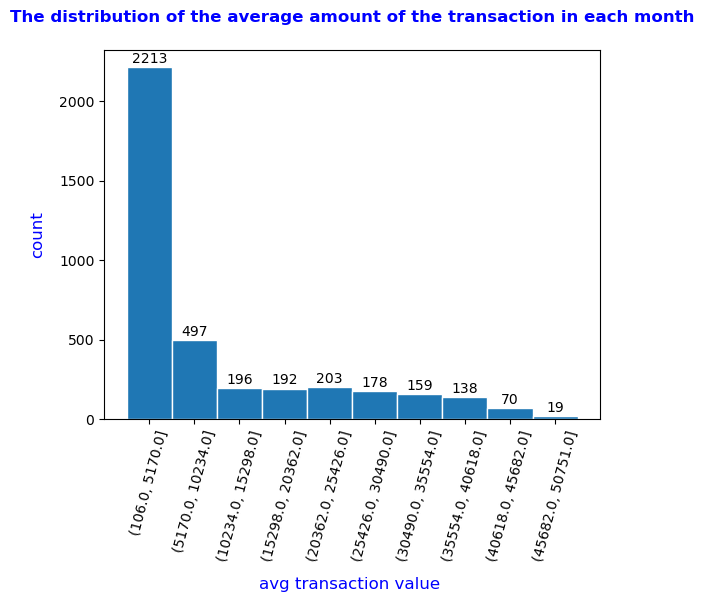

In [10]:
listOfImageNames = ['../plots/avg_amount_count_small.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


large

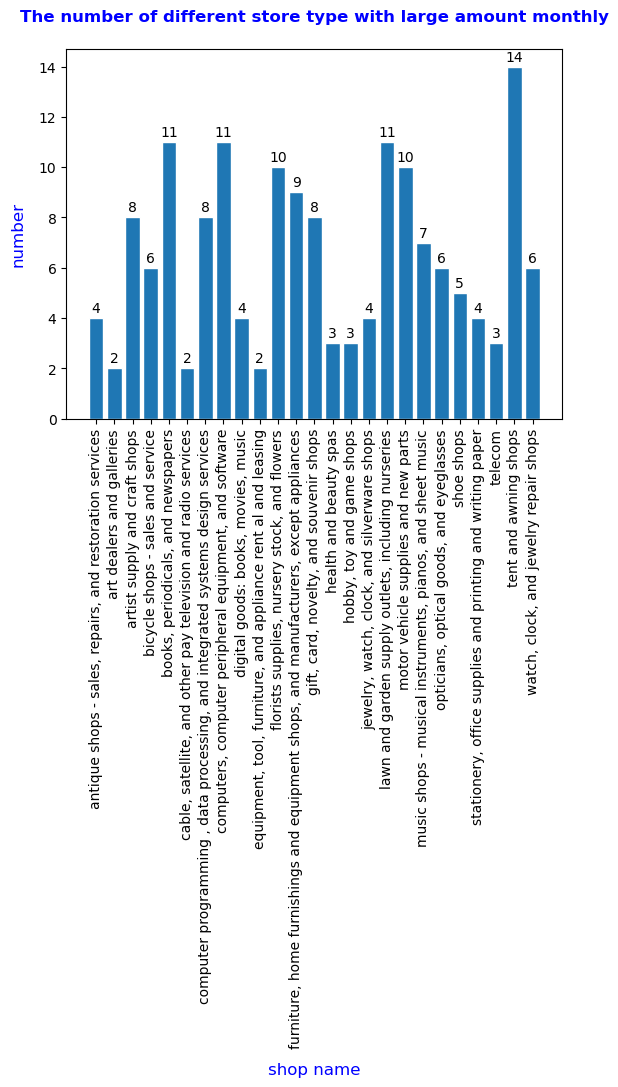

In [11]:
listOfImageNames = ['../plots/store_type_large_amount.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of the average count of the transaction in each month

In order to better observe the data distribution of the amounts in the tables, we distinguished the tables according to the size of the amout. amounts greater than 51,000 were the large amount tables, and on the contrary, amounts less than 51,000 were the small amounts tables.

For the data table with amout less than 51000, we can find that most of the data are concentrated in the first interval, and some in the second interval. The number of companies in the rest of the interval is about the same. The number of companies with large transactions is less. By analyzing the distribution of tags in the large amount data, we can find that the number of large transactions in books and IT companies is the most, and these companies have better development prospects compared to other companies and earn more money.

small

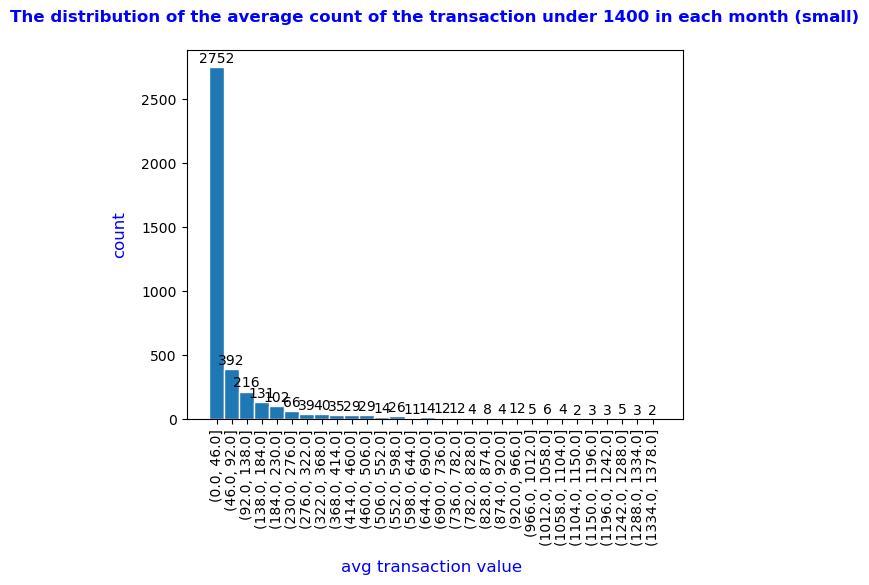

In [12]:
listOfImageNames = ['../plots/Avg_count_monthly_small.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


large

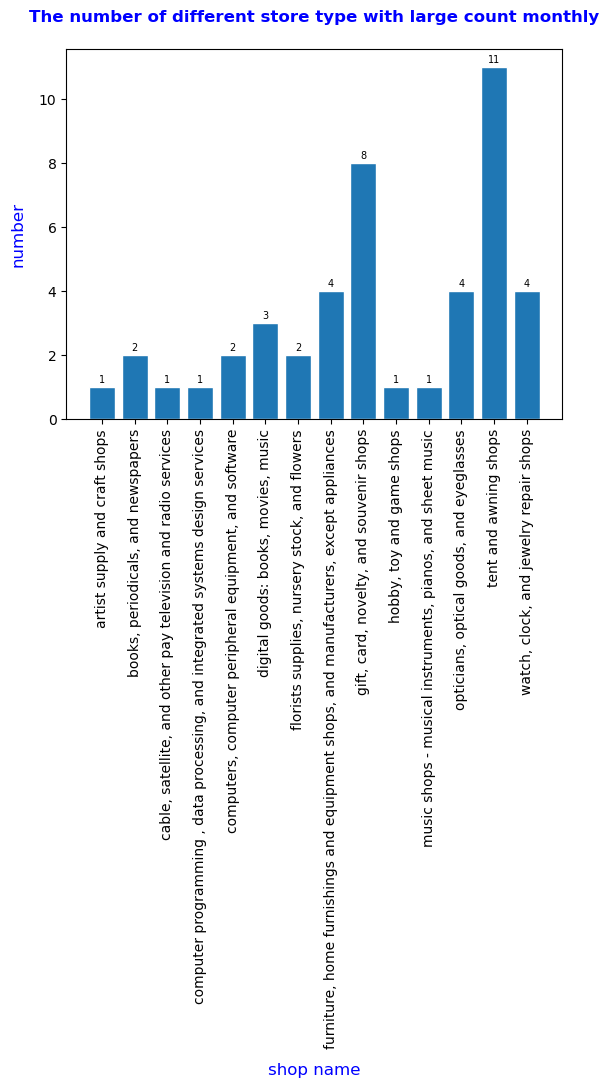

In [13]:
listOfImageNames = ['../plots/store_type_large_count.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The number of different store type

According to the statistics of each merchant's tag, we can find that the number of merchants for digital goods is the largest, followed by the number of watch industry is the smallest. The number of merchants with more than 190 has three types of tags: IT companies, artist supply, and digital goods, which are the three most popular types of merchants among Australians.

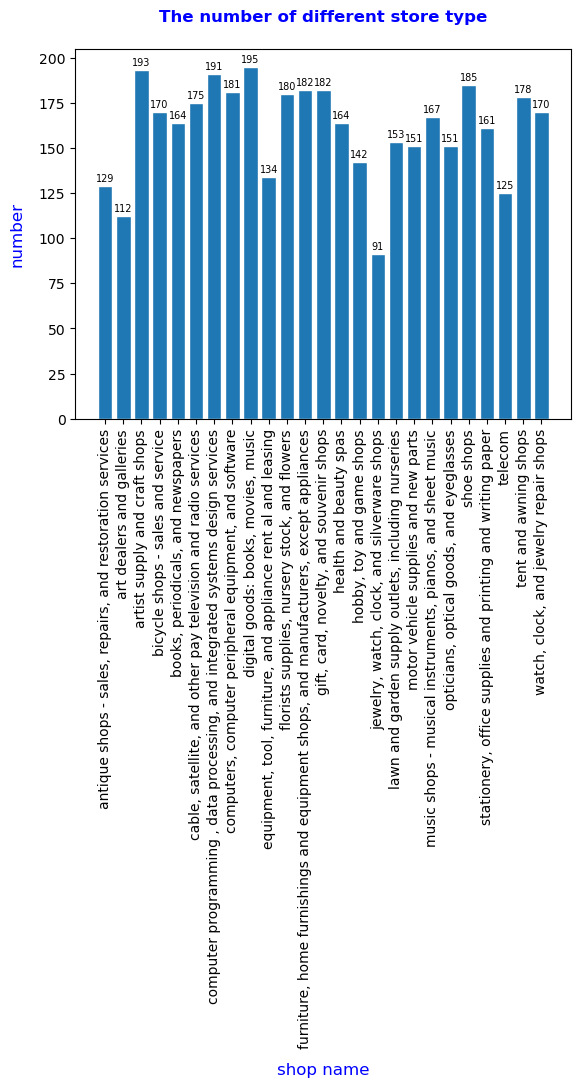

In [14]:
listOfImageNames = ['../plots/store_type.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


### 3.2 Geovisualization

According to the postcode, draw the proportion of the age group between 20-64 in total number of people in that region and the proportion of people earning above the Australian weekly median income ($1200) to the total number of people. The darker the color on the geo graph, the higher the percentage and the higher the consumption level of the people in the region.

## 4. Model

### 4.1 Model Based on Scores  

a. Two ways to do mapping to put all data in the same scale:     
i) Z-score: <font color = #deab8a>New value = (x – μ) / σ</font>       
where x: Original value, μ: Mean of data, σ: Standard deviation of data   

ii) min_max (0-100): <font color = #deab8a>zi = (xi – min(x)) / (max(x) – min(x)) * 100</font>    
where zi: The ith normalized value in the dataset, xi: The ith value in the dataset, min(x): The minimum value in the dataset, max(x): The maximum value in the dataset

b. After mapping, three ways to calculate the final score based on min_max(0-100)    
i) Direct summation as baseline     

In [15]:
pure_add_rank.head()

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,pure_add_score
0,24852446429,"florists supplies, nursery stock, and flowers",50,31.624111,0.0,64.921898,96.614189,0.036051,-8.515757,-0.407453,99.985691,99.153898,52.029317,67.158311,552.600255
1,64203420245,tent and awning shops,50,38.592483,0.0,81.450141,100.000000,0.045806,-8.515943,-0.407393,100.000000,100.000000,32.779992,56.789885,550.734971
2,49891706470,tent and awning shops,0,74.082379,0.0,77.095229,94.727616,0.045767,-8.516445,-0.407453,99.985691,98.385183,32.779992,56.789885,524.967843
3,86578477987,"watch, clock, and jewelry repair shops",0,75.485580,0.0,70.856495,90.948967,0.043376,-8.514694,-0.407433,99.990162,97.415261,32.779992,56.789885,515.387591
4,43186523025,"florists supplies, nursery stock, and flowers",25,53.202677,0.0,71.838573,67.540282,0.062886,-8.518055,-0.408001,99.851542,80.426147,36.992651,54.332438,480.321140


ii) Weighting: subjective weighting    

In [16]:
sorted_self_weight_score.head()

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,weight_score
0,64203420245,tent and awning shops,50,38.592483,0.0,81.450141,100.000000,0.045806,-8.515943,-0.407393,100.000000,100.000000,32.779992,56.789885,1
1,24852446429,"florists supplies, nursery stock, and flowers",50,31.624111,0.0,64.921898,96.614189,0.036051,-8.515757,-0.407453,99.985691,99.153898,52.029317,67.158311,2
2,49891706470,tent and awning shops,0,74.082379,0.0,77.095229,94.727616,0.045767,-8.516445,-0.407453,99.985691,98.385183,32.779992,56.789885,3
3,86578477987,"watch, clock, and jewelry repair shops",0,75.485580,0.0,70.856495,90.948967,0.043376,-8.514694,-0.407433,99.990162,97.415261,32.779992,56.789885,4
4,89726005175,tent and awning shops,0,70.559817,0.0,70.861458,72.621891,0.056852,-8.513618,-0.407676,99.930243,85.626580,32.779992,56.789885,5


iii) Weighting: entropy method    

In [17]:
entropy_score.head()

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank
0,64203420245,tent and awning shops,50,38.592483,0.0,81.450141,100.000000,0.045806,-8.515943,-0.407393,100.000000,100.000000,32.779992,56.789885,650.132412,1
1,49891706470,tent and awning shops,0,74.082379,0.0,77.095229,94.727616,0.045767,-8.516445,-0.407453,99.985691,98.385183,32.779992,56.789885,644.240849,2
2,86578477987,"watch, clock, and jewelry repair shops",0,75.485580,0.0,70.856495,90.948967,0.043376,-8.514694,-0.407433,99.990162,97.415261,32.779992,56.789885,632.826667,3
3,24852446429,"florists supplies, nursery stock, and flowers",50,31.624111,0.0,64.921898,96.614189,0.036051,-8.515757,-0.407453,99.985691,99.153898,52.029317,67.158311,625.765701,4
4,89726005175,tent and awning shops,0,70.559817,0.0,70.861458,72.621891,0.056852,-8.513618,-0.407676,99.930243,85.626580,32.779992,56.789885,566.958596,5


### 4.2 Model Based on Rank    
a. Rank each feature first and then directly adding rank scores together for final rank.     

In [18]:
sum_rank.head()

,merchant_abn,rank_count_of_bigorder,rank_Avg_amount_monthly,rank_Avg_count_monthly,rank_Order_avg_value,rank_avg_prob_fraud_cus,rank_prob_of_fraud,rank_count_cus_per_mon,rank_fix_cus_num,rank_avg_income_percentage,rank_avg_age_percentage,sum_of_ranks,rank
0,82368304209,37,30,517,562,1029,665,503,107,12,54,3516,1
1,18158387243,37,17,164,1276,1790,471,163,102,52,99,4171,2
2,63123845164,37,34,261,1081,1725,197,255,107,410,160,4267,3
3,93260930990,37,8,833,246,930,100,815,107,745,475,4296,4
4,45433476494,37,13,143,1336,1618,549,143,97,396,19,4351,5


b. Reference VCE study score, map the rank with a new score which has the normal distribution with mean is 30, sd is 7 (let the first ranking score is 50). Based on the new ranking score to get the final rank.  

In [19]:
study_score.head()

,merchant_abn,Store_type,Revenue_levels_raw_score,Take_rate_raw_score,count_of_bigorder_raw_score,Avg_amount_monthly_raw_score,Avg_count_monthly_raw_score,Order_avg_value_raw_score,avg_prob_fraud_cus_raw_score,prob_of_fraud_raw_score,count_cus_per_mon_raw_score,fix_cus_num_raw_score,avg_income_percentage_raw_score,avg_age_percentage_raw_score,raw_score_sum,study_rank
0,24852446429,"florists supplies, nursery stock, and flowers",30,42.381937,29.056261,43.558236,48.931409,19.082789,29.744008,27.920837,47.780321,48.931409,33.620434,35.333722,436.341364,1
1,60956456424,"gift, card, novelty, and souvenir shops",20,45.519732,29.327384,48.265653,45.519732,25.703470,30.048319,27.936114,45.519732,45.519732,33.555209,35.230027,432.145102,2
2,64203420245,tent and awning shops,30,42.993348,27.114935,47.076380,50.024708,20.673213,29.733260,27.932296,50.024708,50.024708,26.366466,29.229984,431.194007,3
3,18158387243,health and beauty spas,30,41.597228,26.608027,45.144468,40.018414,32.723814,30.802531,29.287727,40.002125,40.185912,39.476649,34.760216,430.607112,4
4,50315283629,"lawn and garden supply outlets, including nurs...",30,41.386298,26.959618,45.975666,42.240282,30.352764,28.958173,28.421696,42.240282,42.206002,33.357958,31.791273,423.890012,5


### 4.3 Combined Model as Final Model  
Combination of model based on Entropy method and the model based on VCE study score, take the top 100 companies that have high ranks in both ranking methods.  

In [20]:
top_100

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,64203420245,tent and awning shops,50,38.592483,0.000000,81.450141,100.000000,0.045806,-8.515943,-0.407393,100.000000,100.000000,32.779992,56.789885,650.132412,1,3,2.0,1
1,24852446429,"florists supplies, nursery stock, and flowers",50,31.624111,0.000000,64.921898,96.614189,0.036051,-8.515757,-0.407453,99.985691,99.153898,52.029317,67.158311,625.765701,4,1,2.5,2
2,60956456424,"gift, card, novelty, and souvenir shops",25,67.185519,0.000000,86.469133,34.707410,0.160666,-8.497810,-0.407321,96.358303,25.094155,52.029317,67.158311,333.633441,15,2,8.5,3
3,19492220327,"jewelry, watch, clock, and silverware shops",25,52.791573,100.000000,64.629489,0.292273,15.110660,-11.590797,-0.000000,2.751842,0.000000,54.944753,80.548460,396.315022,13,14,13.5,4
4,15043504837,"jewelry, watch, clock, and silverware shops",25,20.522619,58.139535,26.795053,0.070433,25.859384,-15.954168,-0.000000,0.675216,0.000000,68.058198,76.236653,233.794240,22,11,16.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,38090089066,"furniture, home furnishings and equipment shop...",25,35.309729,0.000000,65.776439,17.219463,0.251699,-8.548364,-0.429870,80.901660,2.760151,24.509430,51.332398,182.084292,32,269,150.5,96
96,80982848464,"florists supplies, nursery stock, and flowers",75,1.323830,0.000000,7.591365,2.710030,0.182509,-8.427428,-0.324746,22.943944,0.000000,83.749638,69.692870,61.062171,253,49,151.0,97
97,51279178333,"music shops - musical instruments, pianos, and...",50,1.324785,0.000000,4.346981,6.263200,0.037844,-8.512249,-0.383478,45.342348,0.051592,57.866252,64.690205,69.030070,192,115,153.5,98
98,19933438190,tent and awning shops,50,2.142223,0.000000,5.801701,22.249763,0.007962,-8.517410,-0.404472,88.438148,6.722386,32.779992,56.789885,144.435098,49,265,157.0,99


### 4.4 Top 10 Merchants in 5 Segments  
a. Classification: manually divided into 5 categories: Art & Accessories('art'), Sports & Motors, Technology, Home & Garden, Health & Beauty  
b. Use Final Model to obtain the top10 in each Segments.

In [21]:
art_combine.head(10)

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,19492220327,"jewelry, watch, clock, and silverware shops",25,52.791573,100.000000,64.629489,0.292273,15.110660,-11.590797,-0.000000,2.751842,0.000000,54.944753,80.548460,290.377460,4,4,4.0,1
1,15043504837,"jewelry, watch, clock, and silverware shops",25,20.522619,58.139535,26.795053,0.070433,25.859384,-15.954168,-0.000000,0.675216,0.000000,68.058198,76.236653,167.138081,10,1,5.5,2
2,86578477987,"watch, clock, and jewelry repair shops",0,75.485580,0.000000,70.856495,90.948967,0.043376,-8.514694,-0.407433,99.990162,97.415261,32.779992,56.789885,688.126961,1,14,7.5,3
3,90918180829,"jewelry, watch, clock, and silverware shops",50,19.592859,78.488372,45.127859,0.197958,15.568118,-12.658051,-0.000000,1.897761,0.000000,30.600841,55.513972,216.071923,6,9,7.5,3
4,28057731482,"music shops - musical instruments, pianos, and...",50,24.351576,0.000000,100.000000,4.801743,1.416367,-8.609865,-0.492676,37.307720,0.005159,40.506936,56.931665,161.696416,11,5,8.0,5
5,49322182190,"watch, clock, and jewelry repair shops",0,88.953102,0.000000,84.555266,19.867269,0.281542,-8.542629,-0.419556,85.258818,4.560698,32.779992,56.789885,271.287410,5,11,8.0,5
6,68559320474,"antique shops - sales, repairs, and restoratio...",25,41.709997,0.000000,59.936555,11.816009,0.337527,-8.514193,-0.388620,67.755062,0.613940,32.779992,56.789885,176.827281,9,10,9.5,7
7,64403598239,"music shops - musical instruments, pianos, and...",0,100.000000,0.000000,95.662101,43.501433,0.140636,-8.508302,-0.403368,98.534199,42.072951,36.992651,54.332438,467.337838,3,16,9.5,7
8,39649557865,artist supply and craft shops,50,16.783662,0.000000,68.915094,7.276966,0.638733,-8.523306,-0.463009,50.429277,0.082547,48.076342,56.800536,146.397126,15,7,11.0,9
9,31334588839,"antique shops - sales, repairs, and restoratio...",25,45.401693,41.279070,64.934433,0.525494,8.446610,-9.053458,-0.202020,4.913429,0.000000,30.002678,56.293706,181.655283,7,18,12.5,10


In [22]:
sports_combine.head(10)

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,64203420245,tent and awning shops,50,38.592483,0.0,81.450141,100.000000,0.045806,-8.515943,-0.407393,100.000000,100.000000,32.779992,56.789885,614.235774,1,1,1.0,1
1,49891706470,tent and awning shops,0,74.082379,0.0,77.095229,94.727616,0.045767,-8.516445,-0.407453,99.985691,98.385183,32.779992,56.789885,609.935998,2,2,2.0,2
2,38700038932,tent and awning shops,0,80.475517,0.0,76.979346,2.416171,2.172081,-8.548786,-0.528211,20.688452,0.000000,89.546725,67.853708,150.766595,6,4,5.0,3
3,96680767841,motor vehicle supplies and new parts,0,74.677372,0.0,76.267650,10.447747,0.490058,-8.343844,-0.315134,63.059848,0.402414,38.776020,56.810907,187.995530,4,6,5.0,3
4,22033359776,motor vehicle supplies and new parts,25,35.919911,0.0,69.936717,7.857966,0.599675,-8.423327,-0.317668,53.172176,0.103183,40.379622,53.433307,148.204020,7,12,9.5,5
5,89726005175,tent and awning shops,0,70.559817,0.0,70.861458,72.621891,0.056852,-8.513618,-0.407676,99.930243,85.626580,32.779992,56.789885,536.045929,3,17,10.0,6
6,21359184622,motor vehicle supplies and new parts,25,30.068910,0.0,50.406039,6.925082,0.488689,-8.451374,-0.388866,48.546720,0.056751,35.036396,54.324947,122.882228,15,11,13.0,7
7,31385641294,motor vehicle supplies and new parts,25,42.901238,0.0,57.282585,1.264525,3.092182,-8.474322,-0.478261,11.422337,0.000000,42.056907,89.071439,103.573594,21,5,13.0,7
8,82065156333,tent and awning shops,0,9.056862,0.0,9.273501,21.278537,0.019953,-8.500600,-0.419227,86.510875,5.902079,75.890077,62.619314,131.328298,12,19,15.5,9
9,90568944804,tent and awning shops,25,48.684138,0.0,71.669742,3.561473,1.368363,-8.239194,-0.360206,28.960972,0.000000,40.103629,56.319109,135.388251,11,23,17.0,10


In [23]:
technology_combine.head(10)

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,68216911708,"computers, computer peripheral equipment, and ...",50,24.619604,0.0,48.712897,59.917029,0.045709,-8.522729,-0.408611,99.702189,70.778517,32.779992,56.789885,420.349362,1,2,1.5,1
1,45433476494,"computers, computer peripheral equipment, and ...",0,73.429790,0.0,76.153172,6.036230,0.854169,-8.392925,-0.363265,43.762073,0.051592,43.411469,78.595759,140.125441,6,1,3.5,2
2,35909341340,"computer programming , data processing, and in...",25,58.346334,0.0,73.368014,12.702716,0.385665,-8.505375,-0.416520,70.372755,0.877057,30.615286,62.391680,162.135434,5,7,6.0,3
3,49505931725,"digital goods: books, movies, music",25,44.484492,0.0,57.121682,22.954651,0.160493,-8.520333,-0.402482,88.875474,7.403395,36.992651,54.332438,183.909560,4,10,7.0,4
4,77590625261,"computer programming , data processing, and in...",25,32.281122,0.0,60.132418,8.405290,0.480110,-8.525327,-0.439344,55.407992,0.175411,52.029317,67.158311,119.685284,9,5,7.0,4
5,21439773999,"cable, satellite, and other pay television and...",0,71.209535,0.0,70.458661,40.306303,0.109771,-8.491236,-0.406483,97.779388,35.876799,32.779992,56.789885,316.377239,2,12,7.0,4
6,82368304209,telecom,0,63.180804,0.0,68.709179,1.728915,2.711684,-8.072052,-0.388350,15.347535,0.000000,83.749638,69.692870,107.799284,14,4,9.0,7
7,80518954462,"computers, computer peripheral equipment, and ...",25,35.594298,0.0,61.554990,9.784373,0.421002,-8.501618,-0.399023,61.007369,0.294072,30.615286,62.391680,127.373006,7,11,9.0,7
8,72472909171,"digital goods: books, movies, music",0,55.647382,0.0,53.053343,33.915484,0.097183,-8.482099,-0.397132,96.328790,23.597998,32.779992,56.789885,246.902139,3,18,10.5,9
9,84703983173,"computer programming , data processing, and in...",50,10.139411,0.0,26.477930,13.955393,0.120066,-8.586329,-0.397119,73.811440,1.124697,47.140355,56.721091,110.640225,12,9,10.5,9


In [24]:
home_combine.head(10)

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,24852446429,"florists supplies, nursery stock, and flowers",50,31.624111,0.0,64.921898,96.614189,0.036051,-8.515757,-0.407453,99.985691,99.153898,52.029317,67.158311,568.683600,1,1,1.0,1
1,60956456424,"gift, card, novelty, and souvenir shops",25,67.185519,0.0,86.469133,34.707410,0.160666,-8.497810,-0.407321,96.358303,25.094155,52.029317,67.158311,300.630524,5,2,3.5,2
2,90543168331,"furniture, home furnishings and equipment shop...",50,31.992946,0.0,72.053969,11.806120,0.408086,-8.427985,-0.365711,67.924090,0.650054,46.715266,58.736103,155.390313,13,4,8.5,3
3,50315283629,"lawn and garden supply outlets, including nurs...",50,22.282128,0.0,76.418559,10.009292,0.512999,-8.561754,-0.386754,61.658439,0.319868,51.389456,59.577466,144.547213,14,3,8.5,3
4,41944909975,"books, periodicals, and newspapers",100,1.565573,0.0,59.095986,11.402928,0.345065,-8.580170,-0.456518,66.383165,0.536553,30.615286,62.391680,141.607009,16,7,11.5,5
5,79417999332,"gift, card, novelty, and souvenir shops",25,57.830865,0.0,70.515131,33.266663,0.135219,-8.535702,-0.407974,96.204479,22.638394,30.615286,62.391680,272.542243,6,19,12.5,6
6,76767266140,"furniture, home furnishings and equipment shop...",25,55.675733,0.0,72.267880,14.564380,0.329912,-8.527310,-0.395596,75.351470,1.362018,40.379622,53.433307,172.542445,9,18,13.5,7
7,27093785141,"stationery, office supplies and printing and w...",50,30.922870,0.0,68.367091,8.605860,0.534224,-8.508460,-0.336521,56.098412,0.149616,30.615286,62.391680,138.668598,18,12,15.0,8
8,80324045558,"gift, card, novelty, and souvenir shops",50,10.903412,0.0,44.762200,64.551973,0.037535,-8.519086,-0.408123,99.821135,76.933395,32.779992,56.789885,435.116143,4,26,15.0,8
9,99291944648,"books, periodicals, and newspapers",25,36.822108,0.0,59.580082,5.190383,0.776361,-8.588282,-0.368816,39.061494,0.046432,75.890077,62.619314,113.336544,25,5,15.0,8


In [25]:
health_combine.head(10)

,merchant_abn,Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,fix_cus_num,avg_income_percentage,avg_age_percentage,entropy_score,entropy_rank,study_rank,final_rank_score,final_rank
0,18158387243,health and beauty spas,50,24.598056,0.0,73.139230,5.406532,0.916651,-8.442506,-0.344403,40.388674,0.025796,71.195735,65.483549,126.351791,3,1,2.0,1
1,46804135891,"opticians, optical goods, and eyeglasses",50,21.274757,0.0,43.816246,77.024639,0.028995,-8.517276,-0.407697,99.925771,89.243151,32.779992,56.789885,548.866855,1,4,2.5,2
2,11237511112,"opticians, optical goods, and eyeglasses",50,10.762763,0.0,30.774108,6.829181,0.298854,-8.523077,-0.465357,48.039637,0.072228,61.835607,54.089753,91.803378,6,2,4.0,3
3,48534649627,"opticians, optical goods, and eyeglasses",0,64.035199,0.0,58.202468,21.709716,0.173679,-8.522127,-0.419930,87.549188,6.036217,32.779992,56.789885,195.620671,2,7,4.5,4
4,88699453206,health and beauty spas,25,25.765592,0.0,44.045440,3.975114,0.749160,-8.753224,-0.361465,31.609072,0.000000,40.995622,59.746128,87.827642,7,3,5.0,5
5,95574756848,"opticians, optical goods, and eyeglasses",0,32.378026,0.0,31.761476,3.842365,0.556472,-8.471392,-0.402641,30.843529,0.000000,38.642181,53.082117,73.512596,8,11,9.5,6
6,71674475255,"opticians, optical goods, and eyeglasses",25,6.117938,0.0,9.669480,7.269223,0.081355,-8.309482,-0.354715,50.419439,0.103183,37.934447,63.622604,65.078611,9,10,9.5,6
7,41251795489,"opticians, optical goods, and eyeglasses",50,3.604162,0.0,7.452815,13.244349,0.028686,-8.556425,-0.435685,71.838556,0.913171,32.779992,56.789885,94.681824,5,18,11.5,8
8,25674631453,"opticians, optical goods, and eyeglasses",50,4.659771,0.0,10.965301,4.427004,0.160030,-8.470224,-0.433338,34.391321,0.005159,32.779992,56.789885,59.725834,12,13,12.5,9
9,88547577701,"opticians, optical goods, and eyeglasses",25,8.580504,0.0,11.091403,5.217903,0.135932,-8.483796,-0.390723,39.414753,0.015477,34.369328,55.978791,57.681283,13,12,12.5,9


## 5. Analysis

In [26]:
compare_feature_rank.head(10)

,merchant_abn,final_rank,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank
0,64203420245,1,48,153,6,1,3815,2088,2579,1,1,2917,2173
1,24852446429,2,63,153,37,2,3911,2085,2582,3,2,1058,709
2,60956456424,3,14,153,3,14,3111,2000,2578,14,14,1058,709
3,19492220327,4,28,1,38,1493,117,3834,1,1497,280,830,320
4,15043504837,5,103,3,106,2486,47,3952,1,2484,280,314,434
5,46804135891,6,101,153,76,5,3957,2099,2586,7,5,2917,2173
6,68216911708,7,87,153,62,10,3818,2125,2599,10,10,2917,2173
7,90543168331,8,61,153,19,55,2202,1736,2330,53,52,1435,1668
8,45433476494,9,10,153,13,143,1342,1618,2315,144,126,1630,415
9,80324045558,10,184,153,73,9,3895,2107,2593,9,9,2917,2173


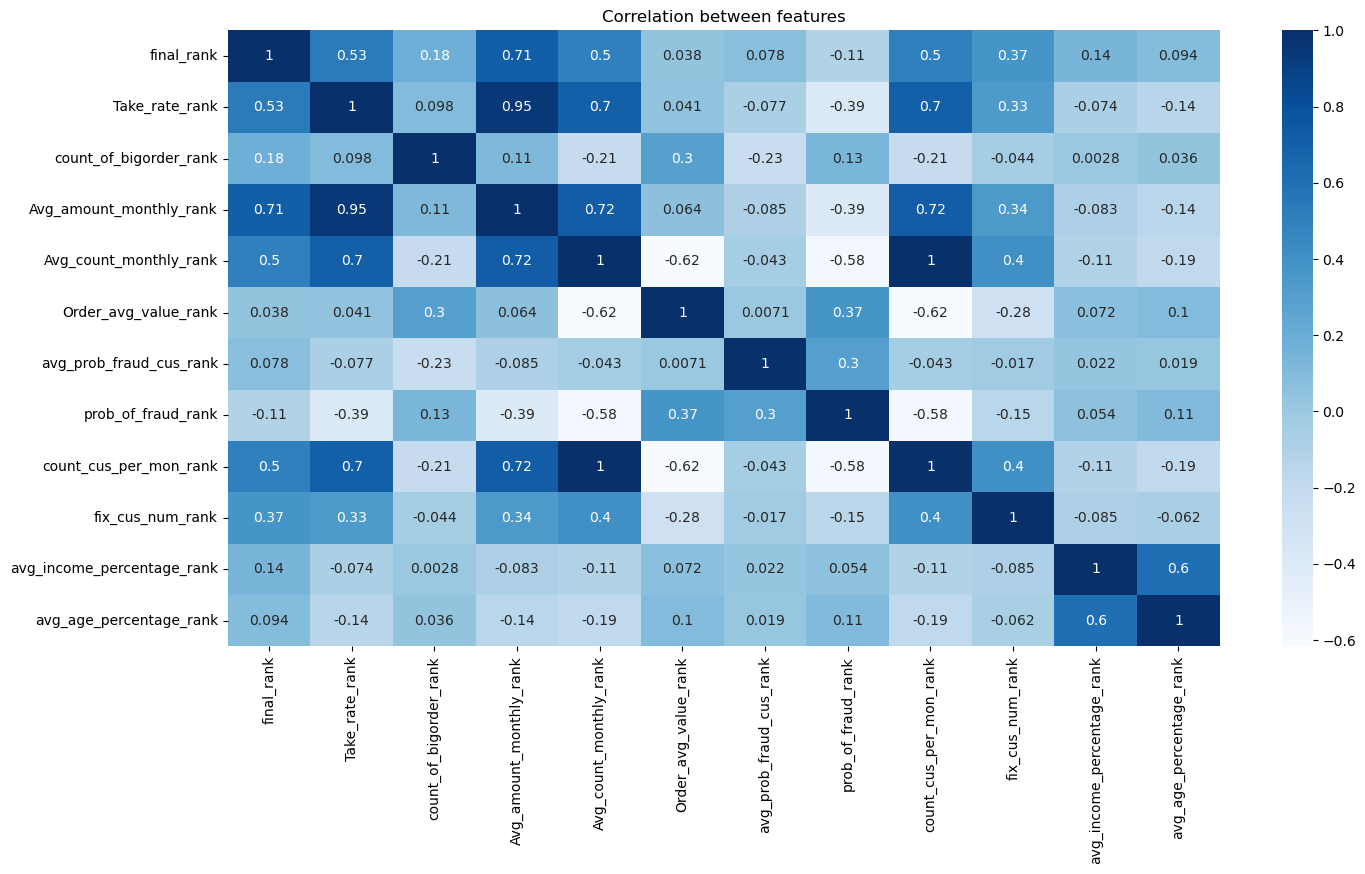

In [27]:
listOfImageNames = ['../plots/heatmap.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))

Avg_amount_monthly_rank greatly seperate merchant should be accepted the correlation is 0.71
take_rate is related to Avg_amount_monthly_rank
